In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sns

#import pylab
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Turning off warnings for neatness
import warnings
warnings.filterwarnings('ignore')

## Introduction

In this project, I demonstrate a few approaches to testing the differences in results achieved via different treatments. This is done on an example of data collected by Yandex (Russia's biggest search engine). The data represents user activity on "control" and "experimental" versions of the page.

Methods used:
- Bootstrapping
- Basic T-Test
- Mann-Whitney test

Notebook demonstrates a few important points:
 - T-Test should only be used after its assumputions are satisfied.
 - There are methods which allow us to perform testing for data which is not normally distributed.
 - The fact that there is a significant difference between the samples is **not** enough to make a correct decision, and researcher should take care to perform additional analysis as required.

In [3]:
# Reading data
Raw=pd.read_csv("ab_browser_test.csv")

## Data Description & Basic Expolration

Data comes from an experiment run by Yandex. The goal of the experiment was to explore if changes to a website affect users actions on the website.

Dataset consists of the following variables:
- **userID**: user's unique ID
- **browser**: browser used by the user
- **slot**: control or experimental group membership
- **n_clicks**: number of clicks user made in n_queries
- **n_queries**: number of queries a user has run
- **n_nonclk_queries**: number of queries where the user did not click any results provided

Our goal is to identify if changes in website positively affected the users.

**We will concentrate our analysis on n_clicks**, however other variables are certainly to be analyzed at a later stage as well.

Additionally, we will try identifiying if there are any additional insights in the data.

In [4]:
print("Rows in file = %.0f, Columns in file=%.0f" % Raw.shape)
Raw.head()

Rows in file = 566134, Columns in file=6


,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [5]:
# Let's compare the mean number of clicks between the two groups
Total_Clicks_Per_Group=Raw.groupby("slot").n_clicks.aggregate(np.mean)

print("Mean number of clicks in exp group is %.3f%% higher than in control" %
      ((Total_Clicks_Per_Group["exp"]*1.0/Total_Clicks_Per_Group["control"]-1)*100))

Mean number of clicks in exp group is 2.687% higher than in control


It seems that in experimental group number of clicks was indeed higher. The difference is not very big - just a couple of percent, but in a digital world it is a lot.

If we prove that this difference is significant later, we can state that proposed change is to be recommended for implementation.

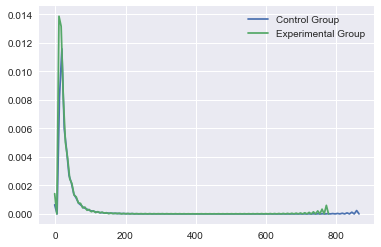

In [6]:
sns.kdeplot(Raw.loc[Raw.slot=="control","n_clicks"],label="Control Group")
sns.kdeplot(Raw.loc[Raw.slot!="control","n_clicks"],label="Experimental Group")
plt.legend();

As seen from the chart, number of clicks distribution is far from normal with a very heavy right tail. It looks more like Poisson, which is to be expected, given the count nature of the data.

## Bootstrapping

Bootstrapping will serve two goals:
1. Allow us to test for diffence between the distributions, without paying much attention to its normality
2. Allow us to test t-test requirements, to see if we can actually use it


### T-test requirements

T-test has two basic requirements:
1. Sample mean is distributed normally, or approximately normally
2. Sample variance estimate is distributed as chi-sq with n-1 degrees of freedom

We will test both of those, to see if we could use t-test on data

In [7]:
## Define bootstrapping function, and function to use its results
def get_bootstrap_samples(data, n_samples):
    data=np.array(data)
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals_from_bootstrap(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [8]:
# Split the data
Exp_Group=Raw[Raw.slot=="exp"]
Control_Group=Raw[Raw.slot=="control"]

# Create bootstraps
Exp_click_bootstraps=get_bootstrap_samples(Exp_Group.n_clicks,500)
Control_click_bootstraps=get_bootstrap_samples(Control_Group.n_clicks,500)

# Calculate means by group from bootstrapped samples
Exp_means=map(np.mean,Exp_click_bootstraps)
Control_means=map(np.mean,Control_click_bootstraps)

# Calculate bootstrapped differences in means between two groups
delta_means = list(map(lambda x: x[1] - x[0], zip(Exp_means, Control_means)))

In [9]:
# Output bootstrapped confidence interval for means
print("Confidence interval for mean difference : [%.3f, %.3f]" %
      tuple(stat_intervals_from_bootstrap(list(delta_means),0.05)))

Confidence interval for mean difference : [-0.408, -0.202]


### Bootstrap mean comparison result
As we see, there is no 0 in bootstraped interval for mean difference. As such, we can say already that there is a significant difference between the two groups.

### T-Test requirements
To check T-test requirements, we will use control group, since distributions in the two groups are rather similar. We will get distribution of sample mean and sample variance estimates via bootstrapping, and see if they are distributed according to T-test requirements

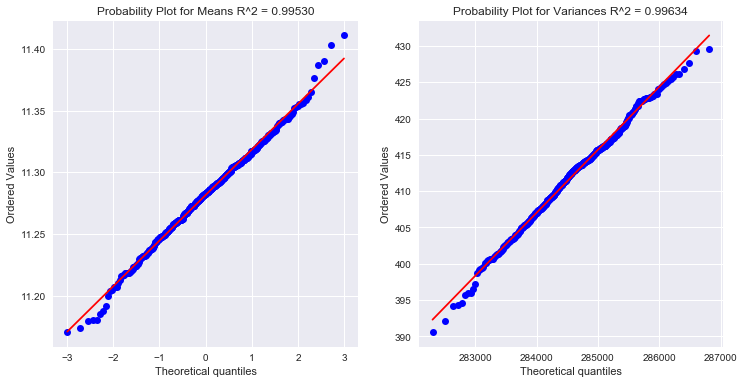

In [15]:
## Calculate distribution of means and variances
Control_means=list(map(np.mean,Control_click_bootstraps))
Control_variance=list(map(np.var,Control_click_bootstraps))


## Create QQ plots for both distributions, comparing
# means with normal
# variances with chisq
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))


Coords,Fit=stats.probplot(Control_means, dist="norm", plot=axes[0],fit=True)
axes[0].set_title('Probability Plot for Means R^2 = %.5f' % (Fit[2]**2))


Coords,Fit=stats.probplot(Control_variance, dist="chi2", 
                     sparams=(len(Control_Group.n_clicks)-1), plot=axes[1],fit=True)
axes[1].set_title('Probability Plot for Variances R^2 = %.5f' % (Fit[2]**2))

plt.show()

### T-Test requirements results
Based on both visual analysis of QQ plots and R^2 obtained, we can conclude that T-test requirements are satisfied - the distributions are quite close to the ones required.

## T-Test

Since T-Test requirements are satisfied, we can use this for testing

In [11]:
print(stats.ttest_ind(Exp_Group.n_clicks,Control_Group.n_clicks,equal_var=False))

Ttest_indResult(statistic=5.6307180410279596, pvalue=1.795455499781595e-08)


Clearly, T-Test also shows us that difference between in number of click is signficiant between the samples.

## Mann-Whitney test
Now, let's pretend that T-Test requirements are not satisfied, and the amount of data is a bit too big to run bootstrapping.
A good option in that case would be to use Mann-Whitney test. Its requirements are not as strict as T-test's, and it may be more efficient on a wide range of distributions.

In [12]:
stats.mannwhitneyu(Exp_Group.n_clicks,Control_Group.n_clicks,alternative="two-sided")

MannwhitneyuResult(statistic=41184125116.0, pvalue=6.2472358013696291e-75)

Yet another proof that difference between the two samples is significant (not that we needed another one, but its a learning excersize after all).

## Depper dive
A poorly-minded data scientist would stop at this point, and say that changes are positive and should be implemented straight away.

However, we are better than this. We have another variable in the dataset - browser. Perhaps, it is a good idea to check if the differences are consistent by browser.

In [13]:
for browser in Raw.browser.unique():
    ThisPiece=Raw[Raw.browser==browser]
    
    Total_Clicks_Per_Group=ThisPiece.groupby("slot").n_clicks.aggregate(np.mean)

    print("Difference for %s %.3f%% higher than in control" %
          (browser,((Total_Clicks_Per_Group["exp"]*1.0/Total_Clicks_Per_Group["control"]-1)*100)))

Difference for Browser #2 0.495% higher than in control
Difference for Browser #4 0.166% higher than in control
Difference for Browser #14 44.336% higher than in control
Difference for Browser #17 0.453% higher than in control
Difference for Browser #20 -0.798% higher than in control
Difference for Browser #22 -1.380% higher than in control


Aha! We can see that difference is only really noticeably positive for Browser #14. We have already stated though, that smaller differences may be quite important as well - let's see if they are significant.

In [14]:
for browser in Raw.browser.unique():
    ThisPiece=Raw[Raw.browser==browser]
    
    ThisPieceExp_Group=ThisPiece[ThisPiece.slot=="exp"]
    ThisPieceControl_Group=ThisPiece[ThisPiece.slot=="control"]
    
    print("P-value for Difference for %s is %.3f##" % 
        (browser,
         stats.mannwhitneyu(ThisPieceExp_Group.n_clicks,ThisPieceControl_Group.n_clicks,alternative="two-sided")[1]))


P-value for Difference for Browser #2 is 0.054##
P-value for Difference for Browser #4 is 0.815##
P-value for Difference for Browser #14 is 0.000##
P-value for Difference for Browser #17 is 0.075##
P-value for Difference for Browser #20 is 0.907##
P-value for Difference for Browser #22 is 0.515##


## Results

### Practical
As expected, difference is only significant for Browser 14. Hence, we can only recommed for the change to be implemented for users on this particular browser.

However, from a useability point of view, it might be of course confusing for users to have different experiences on different browsers. If that's the case, we would rather implement the change for all of them. 
But we can see that for Browser #22 there is a negative effect, which is worrysome. This result is borderline significant. If we would rather implement changes for all browsers, it is recommended to collect more sample, to check that for Browser #22 users we are not going to make the experience worse.

### Method demonstration 
We have demonstrated usage of three different methods for sig testing AB-experiment results. In this particular case, all of the tests we used were appropriate for the data, and yielded similar results.

It is important to notice though, that:
 - Bootstrapping did take some significant amount of time to run - it might be unwise to run in on sample of such size
 - We have pointed out that before using T-Test, we need to check if its requirements are satisfied. However, we do not always have an option to run bootstrapping. In this case, it would've been better to check data itself for normality, and since our data is not normally distributed Mann-Whitney would've been considered a better option.
 - Thoughtless acceptance of total-level result without subgroup analysis would've potentially had a very negative result - we would've implemented a change which might negatively affect users of one of the browsers

